In [34]:
from torchvision.datasets import MNIST
import random
import numpy as np
from PIL import Image
#import transforms.totensor
import torch
import torchvision
import torchvision.datasets.utils as dataset_utils
import matplotlib.pyplot as plt
import os
from torchvision import transforms
import pickle
import math
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Color(MNIST):
    def __init__(self, root, train=True, download=False, transform=False, target_transform= None):
        super(Color, self).__init__(root, train=train, download=download, transform=transform, target_transform =target_transform)
        color_set = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        self.color = random.choice(color_set)

    def __getitem__(self,index ):
        color_set = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        self.color = random.choice(color_set)
        image, label = self.data[index], self.targets[index]
        image=  image.numpy()
        color =  (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        image = np.stack((image,image,image), axis=2)
        image =  np.where(image>0, color, image)
        image= image.astype(np.uint8)
        image= Image.fromarray(image)
        #show image
        #plt.imshow(image)
        plt.show()
#show images
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label


transform = transforms.ToTensor()

#get_item
#rows = math.ceil(len(trainset)/5)
#trainset.__getitem__(0)
#trainset.__getitem__(1)
#do a loop to show all images
#for i in range(len(trainset)):
#    trainset.__getitem__(i)


class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(2352, 512)
        self.linear2 = nn.Linear(512,256)
        self.to_mean_logvar = nn.Linear(256, 2*latent_dims)

    def reparametrization_trick(self, mu, log_var):
        # Using reparameterization trick to sample from a gaussian
        eps = torch.randn_like(log_var)
        return mu + torch.exp(log_var / 2) * eps

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        #print(x.size())
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
        self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return self.reparametrization_trick(mu, log_var)

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 2352)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        z = z.reshape(-1, 3,28,28)
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train(vae, data, epochs=20):
    running_loss = 0
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum') + vae.encoder.kl
            running_loss += loss.item()
            loss.backward()
            opt.step()
        print(f"Epoch loss: {running_loss} \n")
        running_loss = 0.0

    return vae

def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')

    plt.colorbar()
    plt.show()

def plot_reconstructed(autoencoder,  r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = []
    for i, z2 in enumerate(np.linspace(r1[1],r1[0], n)):
        for j, z1 in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[z1, z2]]).to(device)
            x_hat = autoencoder.decoder(z)
            img.append(x_hat)

    img = torch.cat(img)
    img = torchvision.utils.make_grid(img,nrow=12).permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(img,extent=[*r0, *r1])


z_dim = 2
input_dim = 28 * 28 * 3
output_dim = 28 * 28 * 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    #transform = transforms.Compose([transforms.ToTensor()])
    
transform = transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize(0.1307, 0.3081)
        ])
z_dim=2
colored_mnist_train = Color(root='./data', train=True, download=True, transform=transform)
colored_mnist_test = Color(root='./data', train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=colored_mnist_train, batch_size=100, shuffle=True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(dataset=colored_mnist_test, batch_size=100, shuffle=False, num_workers = 4)
vae = VariationalAutoencoder(z_dim).to(device)
    #vae = train(vae, train_loader, epochs=10)
z_dim=2
    #vae = continousVae(z_dim).to(device)
vae.load_state_dict(torch.load("cont_VAE.pkl",map_location=lambda storage, loc: storage))
plot_latent(vae, test_loader)




data_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               transform=torchvision.transforms.ToTensor(),
                               download=True),
    batch_size=100,
    shuffle=True)

#autoencoder = train(autoencoder, data_loader, epochs=20)

data_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               transform=torchvision.transforms.ToTensor(),
                               download=True),
    batch_size=100,
    shuffle=True)

plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))
#autoencoder = train(autoencoder, data_loader, epochs=20)


TypeError: ignored

**Descrete**

In [25]:
#DESCRETE
def sample_gumbel(shape, eps=1e-20):
    #Sample from Gumbel(0, 1)
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, tau=1, eps=1e-20):    
    dims = len(logits.size())
    gumbel_noise = sample_gumbel(logits.size(), eps=eps).to(device)
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):

    bs, N,K = logits.size()    
    y_soft = gumbel_softmax_sample(logits.view(bs*N,K), tau=tau, eps=eps)
    if hard:
        k = torch.argmax(y_soft, dim=-1)
        y_hard = F.one_hot(k, num_classes=K)
        y = y_hard - y_soft.detach() + y_soft
    else:
        y = y_soft
        
    return y.reshape(bs, N*K).to(device)

In [26]:
class DiscreteVAE(nn.Module):
    def __init__(self, latent_dim, categorical_dim):
        super(DiscreteVAE, self).__init__()

        self.fc1 = nn.Linear(2352, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * categorical_dim)

        self.fc4 = nn.Linear(latent_dim * categorical_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 2352)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.N = latent_dim
        self.K = categorical_dim
        
    def encoder(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decoder(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        out = self.sigmoid(self.fc6(h5))
        out = out.view(-1,3,28,28)
        return out

    def forward(self, x, temp, hard):
        q = self.encoder(x.view(-1, 2352).to(device))
        q_y = q.view(q.size(0), self.N, self.K)
        z = gumbel_softmax(q_y, temp, hard)
        return self.decoder(z), F.softmax(q_y, dim=-1).reshape(q.size(0)*self.N, self.K)


In [27]:
N = 3
K = 20  # one-of-K vector

temp = 1.0
hard = False
temp_min = 0.5
ANNEAL_RATE = 0.00003

model = DiscreteVAE(N, K).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, qy):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.shape[0]

    log_ratio = torch.log(qy * qy.size(-1) + 1e-20)
    KLD = torch.sum(qy * log_ratio, dim=-1).mean()

    return BCE + KLD


model = DiscreteVAE(N, K).to(device)
model.load_state_dict(torch.load("desc_VAE.pkl",map_location=lambda storage, loc: storage))
import IPython
ind = torch.zeros(N,1).long()
images_list = []
for k in range(K):
    to_generate = torch.zeros(K*K,N,K)
    index = 0
    for i in range(K):
        for j in range(K):

            ind[1]=k
            ind[0]=i
            ind[2]=j
            z = F.one_hot(ind, num_classes=K).squeeze(1)
            to_generate[index]=z
            index += 1

    generate = to_generate.view(-1,K*N)
    reconst_images= model.decoder(generate.to(device))
    reconst_images = reconst_images.view(reconst_images.size(0), 3, 28, 28).detach()    
    grid_img = torchvision.utils.make_grid(reconst_images.cpu(),nrow=K).permute(1, 2, 0).numpy() * 255
    grid_img = grid_img.astype(np.uint8)
    images_list.append(Image.fromarray(grid_img))



In [28]:

images_list[0].save(
    'c_vae.gif', 
    save_all=True,
    duration=700,
    append_images=images_list[1:],
    loop=10)
IPython.display.IFrame("desc_vae.gif", width=900, height=450)

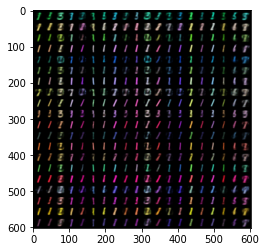

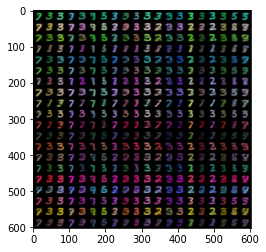

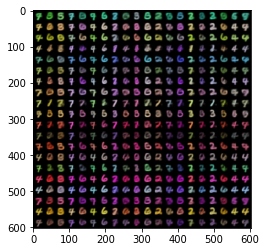

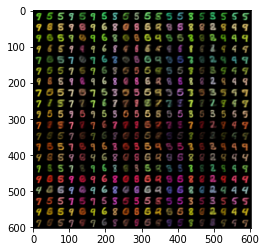

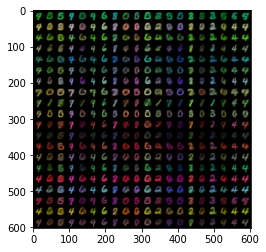

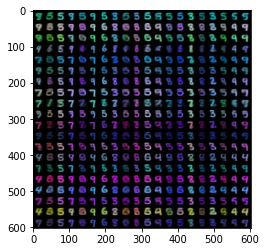

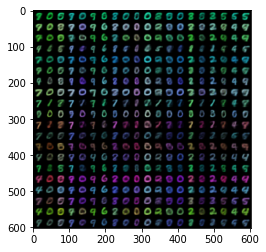

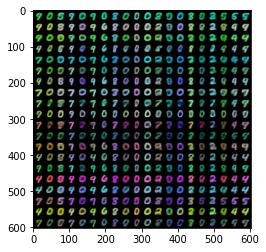

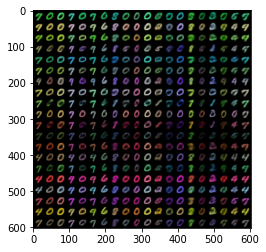

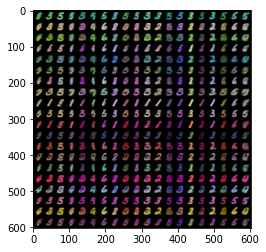

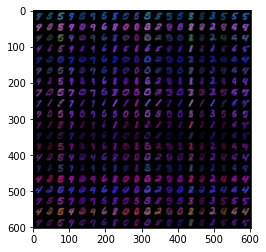

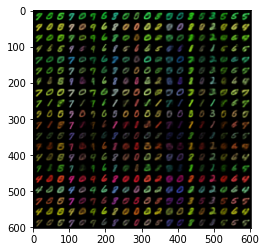

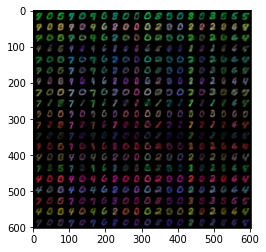

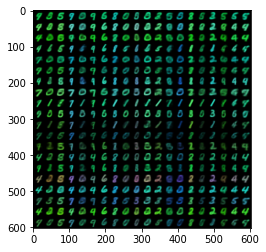

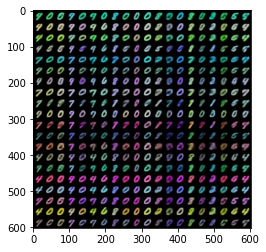

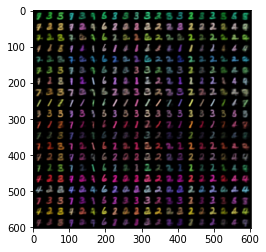

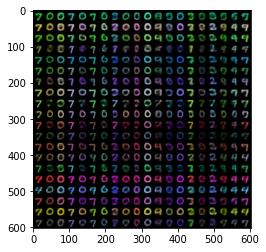

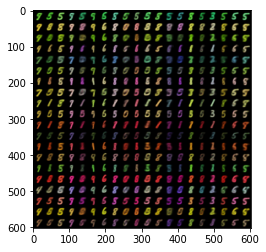

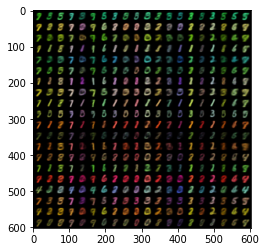

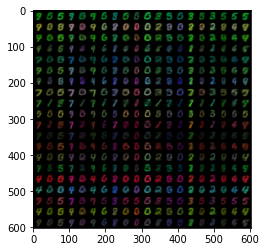

In [29]:
for i in range(len(images_list)):
  plt.imshow(images_list[i])
  plt.show()

**JOINT VAE**

In [17]:
N = 3
K = 20


from torchvision.datasets import MNIST
import random
import numpy as np
from PIL import Image
#import transforms.totensor
import torch
import torchvision
import torchvision.datasets.utils as dataset_utils
import matplotlib.pyplot as plt
import os
from torchvision import transforms
import pickle
import math
import torch.nn as nn
import torch.nn.functional as F

temp = 1.0
hard = False
temp_min = 0.5
ANNEAL_RATE = 0.00003

class JointVAE(nn.Module):
    def __init__(self,z_dim, N, K):
        super(JointVAE, self).__init__()
        self.fc1 = nn.Linear(2352, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_d = nn.Linear(256, N * K)
        self.fc_n = nn.Linear(256, 2 * z_dim)
        self.fc3 = nn.Linear(z_dim + N*K, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 2352)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.N = N
        self.K = K
        self.norm_latent_dim = z_dim

    def reparametrization_trick(self, mu, log_var):
        eps = torch.randn_like(log_var)
        return mu + torch.exp(log_var / 2) * eps


    def encoder_cont(self, x): #encoder cont to copy
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = self.fc_n(h2)
        #x = torch.flatten(x, start_dim=1)
        #x = F.relu(self.linear1(x))
        #mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
        mu, log_var = torch.split(h3, self.norm_latent_dim, dim=-1)
        self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return self.reparametrization_trick(mu, log_var), self.kl #todo: to look if right

    def loss_function_joint(self, recon_x, x, qy, kl):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.shape[0]
        log_ratio = torch.log(qy * qy.size(-1) + 1e-20)
        KLD = torch.sum(qy * log_ratio, dim=-1).mean()

        return BCE + KLD + kl

    def encoder_desc(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        q =  self.relu(self.fc_d(h2))
        q2 = q.view(q.size(0), self.N, self.K)
        z = gumbel_softmax(q2, temp, hard)
        return z, F.softmax(q2, dim=-1).reshape(q.size(0)*self.N, self.K)

    def encoder_combined(self, x , temp, hard):
        input = x.view(-1, 2352)
        z_normal, self.kl = self.encoder_cont(input)
        z_discrete, q2 = self.encoder_desc(input)
        output = torch.cat((z_normal, z_discrete), dim =1)
        return output, q2, self.kl


    def decoder_cont(self, x):
        output = F.relu(self.fc3(x))
        output = F.relu(self.fc4(output))
        output = self.sigmoid(self.fc5(output))
        output = output.view(-1, 3,28,28)
        return output

    def forward(self, input, temp, hard):
        x, q2, self.kl = self.encoder_combined(input, temp, hard)
        x = self.decoder_cont(x)
        return x, q2, self.kl

z_dim=2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = JointVAE(z_dim, N,K)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
num_epochs = 100
temp = 1.0


N = 1
K = 10
temp = 1.0
z_dim = 10
model = JointVAE(z_dim, N, K).to(device)
model.load_state_dict(torch.load("joint_VAE.pkl",map_location=lambda storage, loc: storage))



<All keys matched successfully>

In [18]:
def joint_reconstruction(model, N,K,z_dim):
    images_list = []
    ind = torch.zeros(N,1).long()
    for k in range(K):
        to_generate = torch.zeros(K*K,N,K)
        index = 0
        for i in range(K):
          for j in range(K):

            ind[0]=i
            ind[1]=k
            ind[2]=j
            z = F.one_hot(torch.tensor([k]), num_classes=K).squeeze(1)
            to_generate[index]= z
            index += 1

        generate = to_generate.view(-1,K*N).to(device)
        z_continuous = torch.normal(0, 5, size=(generate.shape[0], z_dim)).to(device)
        generate = torch.cat((z_continuous, generate), dim=1)
        reconst_images= model.decoder_cont(generate)
        reconst_images = reconst_images.view(reconst_images.size(0), 3, 28, 28).detach().cpu() 
        grid_img = torchvision.utils.make_grid(reconst_images,nrow=K).permute(1, 2, 0).numpy() * 255
        grid_img = grid_img.astype(np.uint8)
        images_list.append(Image.fromarray(grid_img))

    return images_list



N = 1
K = 10
temp = 1.0
z_dim = 10

def main(z_dim, N, k):
  model = JointVAE(z_dim, N, K).to(device)
  model.load_state_dict(torch.load("joint_VAE.pkl",map_location=lambda storage, loc: storage))
  images_list = joint_reconstruction(model, N,K,z_dim)
  images_list = joint_reconstruction(model, N,K,z_dim)
  images_list[0].save(
  'j_vae.gif', 
  save_all=True,
  duration=500,
  append_images=images_list[1:],
  loop=1)
  IPython.display.Image("j_vae.gif", width=600, height=600)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
